In [1]:
import pandas as pd
import numpy as np

In [2]:
df_kb = pd.read_csv('data/massIVE-KB/df_kb7to30.csv')
df_uni = pd.read_csv('data/uniprot/df_uni.csv')

In [3]:
print(df_kb.shape)
df_kb.head(1)

(1992213, 10)


,PEPMASS,CHARGE,FILENAME,SEQ,STRIP_PEPTIDE,SCORE,MZ,INTENSITY,SPECTRAL_CNT,PROTEIN
0,623.327626,3,filtered_library_mgf_files/9187af535f6e41ce958...,+42.011AAEAAGGKYRSTVSKSKD,AAEAAGGKYRSTVSKSKD,4.605175,129.10317993164062;130.08726501464844;136.0766...,63295.375;7010.876953125;14278.6826171875;5026...,1,sp|Q96A65|EXOC4_HUMAN


In [4]:
print(df_uni.shape)
df_uni.head(1)

(75074, 3)


,PROTEIN,SEQUENCE,PROTEIN_FULL
0,sp|Q9H553|ALG2_HUMAN,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,">sp|Q9H553|ALG2_HUMAN Alpha-1,3/1,6-mannosyltr..."


In [10]:
print('uniq STRIP_PEPTIDE cnt : {:,}'.format(len(df_kb.STRIP_PEPTIDE.unique())),
     '\nuniq (CHARGE, STRIP_PEPTIDE) cnt : {:,}'.format(len({(c, s) for c, s in df_kb[['CHARGE', 'STRIP_PEPTIDE']].values})),
     '\nuniq (CHARGE, PEPTIDE) = precursor = pk cnt : {:,}'.format(len(df_kb)),
     '\nuniq PEPTIDE cnt : {:,}'.format(len(df_kb.SEQ.unique())))

uniq STRIP_PEPTIDE cnt : 1,025,976 
uniq (CHARGE, STRIP_PEPTIDE) cnt : 1,458,499 
uniq (CHARGE, PEPTIDE) = precursor = pk cnt : 1,992,213 
uniq PEPTIDE cnt : 1,463,972


In [18]:
print('uniq PEPTIDE with no modi cnt : {:,}'.format(
            len({_ for _ in df_kb.SEQ.unique() if '+' not in _})),
     '\nuniq (CHARGE, PEPTIDE with no modi) cnt : {:,}'.format(
            len({(c, _) for c, _ in df_kb[['CHARGE', 'SEQ']].values if '+' not in _})))

uniq PEPTIDE with no modi cnt : 847,161 
uniq (CHARGE, PEPTIDE with no modi) cnt : 1,192,721


# 생각정리
  - PTM_PEPTIDE(SEQ)도 protein에서 ID된것이긴 하니까 STRIP_PEPTIDE 기준으로 detect 된 것으로 판단해야 한다.
  - point 1
      - PTM_PEPTIDE와 noPTM_PEPTIDE를 STRIP_PEPTIDE로 만들 때, spectral count 합쳐야 할까?  
      - protien 기준에서 id peptide를 판단할 때, PTM없이 판단하므로 합치는게 맞다.
  - point 2
      - PTM_PEPTIDE 의 m/z, intensity 와 noPTM_PEPTIDE 의 m/z, intensity가 다를텐데 prosit 기준값은?
      - spectral count는 합치되 m/z, intensity 는 noPTM_PEPTIDE로 병합하자.
  - point 3
      - CHARGE 마다 spectral count 다른데, 합쳐야할까?
      - 1과 같은 의미로 합치는게 맞다.
          - 210829 : 일단 guan's work의 CHARGE prediction모델을 사용할 건데
          - 혹시 성능이 좋지않으면 fine tuning할 때, CHARGE를 나눠서 데이터를 구성해야 할 것이다.
          - 즉, detect_train, detect_test에 CHARGE가 들어가야 할것. (지금은 빼고 구성)

In [75]:
# protein check
p2prot = dict()
for p, prot in df_kb[['STRIP_PEPTIDE', 'PROTEIN']].values:
    if p not in p2prot:
        p2prot[p]=set()
    p2prot[p].add(prot)
    
print('STRIP_PEPTIDE which has protein >2 cnt : ', 
      len([_ for _ in p2prot.values() if len(_) >=2]))

for k, v in p2prot.items():
    k, v = k, *v  # unzip set
    p2prot[k] = v

STRIP_PEPTIDE which has protein >2 cnt :  0


In [76]:
# ptm spectral count merge (plus)
pc2cnt = dict()
for c, p, cnt in df_kb[['CHARGE', 'STRIP_PEPTIDE', 'SPECTRAL_CNT']].values:
    if (p, c) not in pc2cnt:
        pc2cnt[(p, c)] = 0
    pc2cnt[(p, c)] += cnt

In [77]:
# spectrum check
# 84만개의 no PTM PEPTIDE
pc2mz = dict()
pc2int = dict()
for p, c, m, i in df_kb[['SEQ', 'CHARGE', 'MZ', 'INTENSITY']].values:  
    if '+' not in p:
        pc2mz[(p, c)] = m
        pc2int[(p, c)] = i

# spectrum check
# 20만개의 PTM PEPTIDE
noptm_pc = {(_, c) for c, _ in df_kb[['CHARGE', 'SEQ']].values if '+' not in _}
whole_pep = {(_, c) for c, _ in df_kb[['CHARGE', 'STRIP_PEPTIDE']].values}
ptm_pep_candi = {k:set() for k in list(whole_pep.difference(noptm_pep))}

# PTM_PEPTIDE candidate
# ptm_pep_candi = (STRIP_PEPTIDE, CHARGE):(PTM_PEPTIDE, CHARGE)
for c, p, seq in df_kb[['CHARGE', 'STRIP_PEPTIDE', 'SEQ']].values:
    if (p, c) in ptm_pep_candi:
        ptm_pep_candi[(p, c)].add((seq, c))

pc2score_look = {(p, c):score for p, c, score in df_kb[['SEQ', 'CHARGE', 'SCORE']].values}
pc2mz_look = {(p, c):mz for p, c, mz in df_kb[['SEQ' ,'CHARGE', 'MZ']].values}
pc2int_look = {(p, c):i for p, c, i in df_kb[['SEQ' ,'CHARGE', 'INTENSITY']].values}

for k, v in ptm_pep_candi.items():
    if len(v)==1:
        v = list(v)[0]
        pc2mz[k] = pc2mz_look[v]
        pc2int[k] = pc2int_look[v]
    else:  # choose high SCORE's SEQ
        ptm_seqs = {ptm_seq:pc2score_look[ptm_seq] for ptm_seq in v}
        best_v = sorted(ptm_seqs.items(), key=lambda x: x[1], reverse=True)[0][0]  # 내림차순
        pc2mz[k] = pc2mz_look[best_v]
        pc2int[k] = pc2int_look[best_v]

In [81]:
pc = {(p,c) for p, c in df_kb[['STRIP_PEPTIDE', 'CHARGE']].values}
df_ided_peptide = pd.DataFrame([[c, p, p2prot[p], pc2cnt[(p,c)], pc2mz[(p,c)], pc2int[(p,c)]]
                                for p, c in pc],
                              columns=['CHARGE', 'PEPTIDE', 'PROTEINS', 
                                       'SPECTRAL_CNT', 'MZ', 'INTENSITY'])

In [82]:
print(df_ided_peptide.shape)
df_ided_peptide.head(2)

(1458499, 6)


,CHARGE,PEPTIDE,PROTEINS,SPECTRAL_CNT,MZ,INTENSITY
0,3,KSTLASVNIQALPDKGQK,sp|Q9UNY4|TTF2_HUMAN,2,101.07149505615234;102.0557861328125;110.07170...,149737.359375;25633.95703125;215093.203125;678...
1,2,DEENTANSFLNYR,sp|Q12864|CAD17_HUMAN,8,102.05529022216797;120.08084869384766;129.0657...,19837.28515625;26364.921875;15893.0185546875;1...


# protein filtration 
  - sequence coverage >= 0.5

In [2]:
import pandas as pd
import numpy as np

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
%matplotlib inline

from making_data_modified_miss_threshold import *

In [3]:
# %matplotlib inline
# %matplotlib notebook

In [4]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_'+metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_'+metric])

In [5]:
# df_kb = pd.read_csv('data/multishot/df_kb_final.csv')
df_kb = pd.read_csv('data/predictCharge/positive.csv')
df_kb_uni = pd.read_csv('data/multishot/df_uni_final.csv')

prot = [__ for _ in df_kb.protein.values for __ in _.split(';')]
print('unique protein cnt : {:,}\nunique stripped peptide cnt : {:,}'.format(
    len(set(prot)), len(df_kb.peptide.unique())))
df_kb.head(1)

unique protein cnt : 19,301
unique stripped peptide cnt : 1,075,839


,peptide,CHARGE,protein,spectral_count
0,AAEAAGGKYRSTVSKSKD,3,sp|Q96A65|EXOC4_HUMAN,1


In [6]:
df_kb_uni.head(1)

,protein,sequence
0,sp|Q9H553|ALG2_HUMAN,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...


In [7]:
tmp = open('data/multishot/uniprot-proteome_UP000005640.fasta', 'r')
uni_lines = tmp.readlines()
tmp.close()

uni_dic = {'PROTEIN':[], 'SEQ':[]}
tmp = ''  # initialize
for idx, line in enumerate(uni_lines):
    l = line.replace('\n', '')
    if '>' in l:
        if idx!=0:
            uni_dic['SEQ'].append(tmp)
        uni_dic['PROTEIN'].append(l)
        tmp = ''  # initialize
    else:
        tmp += l

    if idx + 1 == len(uni_lines):  # end line of db
        uni_dic['SEQ'].append(tmp)

df_uni = pd.DataFrame(uni_dic)

df_uni['prot'] = [i.replace('>', '').split(' ')[0] for i in df_uni.PROTEIN.values]

In [8]:
df_hk = pd.read_csv('data/SL/housekeeping/tissue_category_rna_any_detected.tsv', sep='\t')
print(df_hk.shape)
df_hk.head(2)

hk_prots = list(set(df_hk.Uniprot.values).difference({np.nan}))
print('housekeeping protein cnt : ', len(hk_prots))

uni_prots = df_uni.prot.apply(lambda x: x.split("|")[1]).values
print('house & uniprot cnt ', len(set(hk_prots).intersection(uni_prots)))

result_prots = list(set(hk_prots).intersection(uni_prots))

df_unihk = df_uni.copy()
df_unihk['key'] = df_unihk.prot.apply(lambda x: x.split('|')[1]).values
df_key = pd.DataFrame(result_prots, columns=['key'])
df_kb_uni = df_unihk.merge(df_key, how='inner').reset_index(drop=True).drop('key', axis=1)

(9638, 292)
housekeeping protein cnt :  9473
house & uniprot cnt  9441


In [9]:
df_kb_uni = df_kb_uni.drop('PROTEIN', axis=1).rename({'prot':'protein', 'SEQ':'sequence'}, axis=1)

In [10]:
print('unique DB protein cnt : {:,}'.format(len(df_kb_uni.protein.unique())))
df_kb_uni.head(1)

unique DB protein cnt : 9,441


,sequence,protein
0,MAEEQGRERDSVPKPSVLFLHPDLGVGGAERLVLDAALALQARGCS...,sp|Q9H553|ALG2_HUMAN


In [11]:
kb_tree = make_tree(df_kb)

cover_cnt = [[0 for __ in range(len(_))] for _ in df_kb_uni.sequence.values]
cover_prot_idx = []
coverage_dic = {pname:0 for pname in df_kb_uni.protein.values}
for prot_idx, (prot_seq, pname) in enumerate(df_kb_uni[['sequence', 'protein']].values):
    pep_results = kb_tree.search_all(prot_seq)

    for pep_result in pep_results:  # result = ('ACAC', 5) = (peptide, location)
        change_range = range(pep_result[1], pep_result[1] + len(pep_result[0]))
        for idx, value in enumerate(cover_cnt[prot_idx]):
            if idx in change_range:
                value += 1
                cover_cnt[prot_idx][idx] = value
    cov = sum([1 for _ in cover_cnt[prot_idx] if _ >= 1]) / len(cover_cnt[prot_idx])
    if cov >= 1/2:
        cover_prot_idx.append(prot_idx)
    coverage_dic[pname] = cov

sc_dic = {p:0 for p in [__ for _ in df_kb.protein.values for __ in _.split(';')]}
for ps, sc in df_kb[['protein', 'spectral_count']].values:
    pl =  ps.split(';')
    for p in pl:
        sc_dic[p] += sc  
df_y_sc = pd.DataFrame({'protein':sc_dic.keys(),
                        'SC':sc_dic.values()}).sort_values('SC', ascending=False)

df_y_cover = pd.DataFrame([[one, round(two, 2)]
                           for one, two in coverage_dic.items()
                           if one in df_y_sc.protein.values],
                           columns=['protein', 'C']).sort_values('C', ascending=False)

In [12]:
c_prot = df_y_cover.loc[df_y_cover.C>=0.5].protein.values
remain_prot = c_prot
print('follow AP3 filteration method : ', len(remain_prot))

digest_prot = remain_prot[:int(len(remain_prot)/2)]
detect_prot = remain_prot[int(len(remain_prot)/2):]

digest_idx = [idx for idx, _ in enumerate(df_kb_uni.protein.values) if _ in digest_prot]
detect_idx = [idx for idx, _ in enumerate(df_kb_uni.protein.values) if _ in detect_prot]
df_y_digest = df_kb_uni.loc[digest_idx].reset_index(drop=True)
df_y_detect = df_kb_uni.loc[detect_idx].reset_index(drop=True)

PC, PCmiss = counting(pep_tree=kb_tree, df_prot=df_y_digest, types='sc', df_pep=df_kb)
data_dicKR15 = labeling(PC, PCmiss, 7)
df_multi15_kr = preprocessing(data_dicKR15)

print(df_y_digest.shape, df_y_detect.shape)

follow AP3 filteration method :  7110
counting... 0 / 3555
peptide counting done!
 P, unique p: (28699, 28699) 
 n, unique n: (8607, 8607) 
 total : 37,306
remove P:0, N:0
 P, unique p: (28699, 28699) 
 n, unique n: (8607, 8607) 
 total : (37306, 37306)
X aa cnt : 0
(3555, 2) (3555, 2)


In [13]:
def clf_digest(df_multi_kr):
    ts = []
    for idx in range(len(df_multi_kr)):
        tryptic_site = df_multi_kr.tryptic_site.values[idx]
        ts.append([0 if a != amino_acid else 1 
                   for amino_acid in tryptic_site 
                   for a in 'ARNDCQEGHILKMFPSTWYVZ'])

    # df_multi_kr_onehot
    df_multi_kr_onehot = pd.concat([pd.DataFrame(ts), pd.DataFrame(df_multi_kr.label).
                                    reset_index(drop=True)], axis=1)

    # Positive to 1, Negative to 0
    label_dic = {'P':1, 'N':0}
    df_multi_kr_onehot['label'] = df_multi_kr_onehot.label.apply(lambda x: label_dic[x])

    X = df_multi_kr_onehot.drop(['label'], axis=1).values
    y = df_multi_kr_onehot.loc[:, 'label'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=77)
    print('train set ratio : P {:,}, N {:,}'.format(len(np.where(y_train==1)[0]), len(np.where(y_train==0)[0])))
    print('test set ratio : P {:,}, N {:,}'.format(len(np.where(y_test==1)[0]), len(np.where(y_test==0)[0])))
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    clf_multi_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
    clf_multi_digest.fit(X_train, y_train)

    # prediction
    y_pred = clf_multi_digest.predict(X_test)
    print(classification_report(y_test, y_pred))
    # AUC
    probs = clf_multi_digest.predict_proba(X_test)[:, 1]
    rf_auc = roc_auc_score(y_test, probs)
    print('rf auc : {}'.format(rf_auc))
    # plot the roc curve for the model
    rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
    plt.figure(figsize=(4, 4))
    plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
    plt.title('ROC curve')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # show the legend
    plt.legend()
    # show the plot
    plt.show()
    plt.figure(figsize=(3, 3))
    cf_matrix = confusion_matrix(y_test, y_pred)
    sns.heatmap(cf_matrix, annot=True, fmt=',.0f')
    plt.show()
    plt.figure(figsize=(3, 3))
    sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
                fmt='.2%', cmap='Blues')
    plt.show()

    clf_multi_digest = RandomForestClassifier(n_estimators=200, max_features='sqrt')
    clf_multi_digest.fit(X, y)
    return clf_multi_digest

train set ratio : P 19,221, N 5,774
test set ratio : P 9,478, N 2,833
(24995, 315) (24995,) (12311, 315) (12311,)
              precision    recall  f1-score   support

           0       0.93      0.76      0.83      2833
           1       0.93      0.98      0.96      9478

    accuracy                           0.93     12311
   macro avg       0.93      0.87      0.90     12311
weighted avg       0.93      0.93      0.93     12311

rf auc : 0.9747440093308397


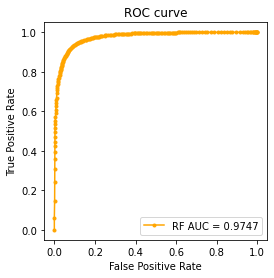

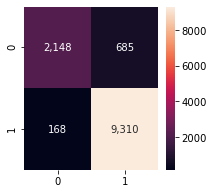

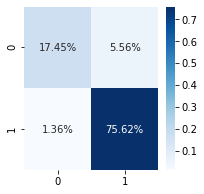

In [14]:
clf = clf_digest(df_multi15_kr) # 원래 라벨링으로 만든 훈련모델.

In [15]:
# df_multi15_kr.to_csv('data/SL/df_housekeeping_digestTrain_210706.csv',index=False)

# Making Detect data

In [16]:
def make_data(df_uni, miss_cnt, thres=4, PC=None, PCmiss=None):
    peptide = []

    TS_AA = 'KR'
    MISS_CLEAVAGE = miss_cnt

    for protein, pc, pcmiss in zip(df_uni.sequence.values, PC, PCmiss):
        ts_idx = []  # tryptic site index
        for prot_idx, aa in enumerate(protein):
            if aa in TS_AA:
                ts_idx.append(prot_idx)
        for idx in range(len(ts_idx)):
            n = MISS_CLEAVAGE
            if idx+(n+1) > len(ts_idx)-1:  # peptide making range
                break

            # protein N term
            if (ts_idx[idx]<=(thres - 1)) and (ts_idx[idx] >= len(protein) -1 -(thres - 1)):  # -MNQKLLK- 앞뒤 다 부족한 경우
                en = 'Z' * (thres - ts_idx[idx]) + protein[: ts_idx[idx]+(thres + 1)] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx]))
            elif ts_idx[idx]<=(thres - 1):
                en = 'Z' * (thres - ts_idx[idx]) + protein[: ts_idx[idx]+(thres + 1)]
            elif ts_idx[idx] >= len(protein) -1 -(thres - 1):  # for EAQDRRN : 끝이 부족한 경우
                en = protein[ts_idx[idx]-thres:] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx]))
            else:
                en = protein[ts_idx[idx]-thres: ts_idx[idx]+(thres + 1)]

            # protein C term
            if (ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1)) and (ts_idx[idx+n+1] <= (thres - 1)):
                ec = 'Z' * (thres - ts_idx[idx+n+1]) + protein[: ts_idx[idx+n+1]+(thres + 1)]  + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1):
                ec = protein[ts_idx[idx+n+1] - thres :] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx+n+1] <= (thres - 1):  # for -MRRS : 시작이 부족한 경우
                ec = 'Z' * (thres - ts_idx[idx+n+1]) + protein[: ts_idx[idx+n+1]+(thres + 1)]
            else:
                ec = protein[ts_idx[idx+n+1] - thres : ts_idx[idx+n+1] +(thres + 1)]  # n+1번째 tryptic_site
                    
            # Peptide miss cleavage
            if n != 0:  # miss cleavage 고려하는 경우,
                ei = []
                for i in range(1, n+1):
                    if ts_idx[idx+i] >= len(protein) -1 -(thres - 1):
                        ei_tmp = protein[ts_idx[idx+i] - thres :] + 'Z' * (thres - (len(protein)-1 - ts_idx[idx+i]))
                    elif ts_idx[idx+i] <= (thres - 1):
                        ei_tmp = 'Z' * (thres - ts_idx[idx+i]) + protein[: ts_idx[idx+i]+(thres + 1)]
                    else:
                        ei_tmp = protein[ts_idx[idx+i] - thres : ts_idx[idx+i] +(thres + 1)]
                    ei.append(ei_tmp)
            else:  # miss cleavage 고려안하는 경우
                ei = []
            # peptide
            if ts_idx[idx+n+1] == len(protein)-1:  # protein C term = idx + n + 1 의 tryptic_site 가 단백질의 마지막인 경우
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.Z'
            else:
                pep = protein[ts_idx[idx]] + '.' + protein[ts_idx[idx]+1:ts_idx[idx+n+1]+1] + '.' + protein[ts_idx[idx+n+1]+1]
            
            # spectral counts                
            # sc
            if (ts_idx[idx]<=(thres - 1)) and (ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1)):  # -MNQKLLK- 앞뒤 다 부족한 경우
                sc = [0] * (thres - ts_idx[idx]) + pc[: ts_idx[idx+n+1]+(thres + 1)] + [0] * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx]<=(thres - 1):  # 시작
                sc = [0] * (thres - ts_idx[idx]) + pc[: ts_idx[idx+n+1]+(thres + 1)]
            elif ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1):  # for EAQDRRN : 끝이 부족한 경우
                sc = pc[ts_idx[idx]-thres :] + [0] * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            else:
                sc = pc[ts_idx[idx]-thres: ts_idx[idx+n+1] +(thres + 1)]
            
            if (ts_idx[idx]<=(thres - 1)) and (ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1)):  # -MNQKLLK- 앞뒤 다 부족한 경우
                scm = [0] * (thres - ts_idx[idx]) + pcmiss[: ts_idx[idx+n+1]+(thres + 1)] + [0] * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            elif ts_idx[idx]<=(thres - 1):  # 시작
                scm = [0] * (thres - ts_idx[idx]) + pcmiss[: ts_idx[idx+n+1]+(thres + 1)]
            elif ts_idx[idx+n+1] >= len(protein) -1 -(thres - 1):  # for EAQDRRN : 끝이 부족한 경우
                scm = pcmiss[ts_idx[idx]-thres :] + [0] * (thres - (len(protein)-1 - ts_idx[idx+n+1]))
            else:
                scm = pcmiss[ts_idx[idx]-thres: ts_idx[idx+n+1] +(thres + 1)]

            peptide.append({pep:[[en], [ec], ei, sc, scm]})
    return peptide

def onehotEnc(seqs):
    result = []
    for seq in seqs:
        onehot_seq = []
        for amino_acid in seq:
            for a in 'ARNDCQEGHILKMFPSTWYVZ':
                if a!=amino_acid:
                    onehot_seq.append(0)
                else:
                    onehot_seq.append(1)
        result.append(onehot_seq)
    return result

In [17]:
PC, PCmiss = counting(pep_tree=kb_tree,
                      df_prot=df_y_detect,
                      types='sc', 
                      df_pep=df_kb)

sc = [[int(_[2:]) for _ in __] for __ in PC]
smc = [[int(_[2:]) for _ in __] for __ in PCmiss]

thres=7
PC=sc
PCmiss=smc

# make data
peptide0 = make_data(df_y_detect, 0, thres=thres, PC=PC, PCmiss=PCmiss)
peps = [list(dic.keys())[0] for dic in peptide0]
ens = [list(dic.values())[0][0] for dic in peptide0]
ecs = [list(dic.values())[0][1] for dic in peptide0]
eis = [list(dic.values())[0][2] for dic in peptide0]
cnt = [list(dic.values())[0][3] for dic in peptide0]
cntm = [list(dic.values())[0][4] for dic in peptide0]
zero = pd.DataFrame([[a, b[0], c[0], '-', '-', e, f] 
                     for a, b, c, d, e, f in zip(peps, ens, ecs, eis, cnt, cntm)],
            columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'pc', 'pcmiss'])
zero['PEP'] = [i.split('.')[1] for i in zero.peptide.values]

peptide1 = make_data(df_y_detect, 1, thres=thres, PC=PC, PCmiss=PCmiss)
peps = [list(dic.keys())[0] for dic in peptide1]
ens = [list(dic.values())[0][0] for dic in peptide1]
ecs = [list(dic.values())[0][1] for dic in peptide1]
eis = [list(dic.values())[0][2] for dic in peptide1]
cnt = [list(dic.values())[0][3] for dic in peptide1]
cntm = [list(dic.values())[0][4] for dic in peptide1]
one = pd.DataFrame([[a, b[0], c[0], d[0], '-', e, f]
                    for a, b, c, d, e, f in zip(peps, ens, ecs, eis, cnt, cntm)],
            columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'pc', 'pcmiss'])
one['PEP'] = [i.split('.')[1] for i in one.peptide.values]

peptide2 = make_data(df_y_detect, 2, thres=thres, PC=PC, PCmiss=PCmiss)
peps = [list(dic.keys())[0] for dic in peptide2]
ens = [list(dic.values())[0][0] for dic in peptide2]
ecs = [list(dic.values())[0][1] for dic in peptide2]
eis = [list(dic.values())[0][2] for dic in peptide2]
cnt = [list(dic.values())[0][3] for dic in peptide2]
cntm = [list(dic.values())[0][4] for dic in peptide2]
two = pd.DataFrame([[a, b[0], c[0], d[0], d[1], e, f]
                    for a, b, c, d, e, f in zip(peps, ens, ecs, eis, cnt, cntm)],
            columns=['peptide', 'En', 'Ec', 'E1', 'E2', 'pc', 'pcmiss'])
two['PEP'] = [i.split('.')[1] for i in two.peptide.values]

print('miss0 cnt :{:,}\n miss1 cnt: :{:,}\n miss2 cnt: {:,}'.format(len(zero), len(one), len(two)))

zero_len = zero.loc[zero.PEP.apply(lambda x: (len(x)>=6) and (len(x)<=40))]
one_len = one.loc[one.PEP.apply(lambda x: (len(x)>=6) and (len(x)<=40))]
two_len = two.loc[two.PEP.apply(lambda x: (len(x)>=6) and (len(x)<=40))]
print('after length filtering// \nmiss0 cnt :{:,}\n miss1 cnt: :{:,}\n miss2 cnt: {:,}'.format(len(zero_len), len(one_len), len(two_len)))
df_fully = pd.concat([zero_len, one_len, two_len], axis=0).reset_index(drop=True)
print(df_fully.shape)

# preprocessing
amino = list("ARNDCEQGHILKMFPSTWYVZ")
check_u = [idx for idx, t in enumerate(df_fully.PEP.values) if 'U' in t]
check_x = [idx for idx, t in enumerate(df_fully.PEP.values) if 'X' in t]
check = list(set(check_u).union(set(check_x)))
print(len(check))
df_fully = df_fully.drop(check).reset_index(drop=True)

amino = list("ARNDCEQGHILKMFPSTWYVZ")
check_n = [idx for idx, t in enumerate(df_fully.En.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
check_c = [idx for idx, t in enumerate(df_fully.Ec.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
check_1 = [idx for idx, t in enumerate(df_fully.E1.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
check_2 = [idx for idx, t in enumerate(df_fully.E2.values) if (sum([1 for a in t if a not in amino]) >= 1) and t !='-']
check = list(set(check_n).union(set(check_c)).union(set(check_1)).union(set(check_2)))
print(len(check))
df_fully = df_fully.drop(check).reset_index(drop=True)

sc_dic = {k:v for k, v in df_kb[['peptide', 'spectral_count']].values}
for k in df_fully.PEP.values:
    if k not in sc_dic:
        sc_dic[k] = 0

ided = []
for fully_pep in df_fully.PEP.values:
    results = [i for i in kb_tree.search_all(fully_pep)]
    if len(results) != 0:
        result_pep = [_[0] for _ in results]
        if fully_pep in result_pep:  # 정확히 똑같은 pep 있는 경우
            if sc_dic[fully_pep] > 1:
                ided.append(1)
            else:
                ided.append(-1)  # SC1인 경우는 제거하자
        else:
            ided.append(0)
    else:
        ided.append(0)
df_fully['ID'] = ided

drop_idx = df_fully.loc[df_fully.ID==-1].index
df_fully = df_fully.drop(drop_idx).reset_index(drop=True)

# miss feature labeling
idx1=list(df_fully.loc[df_fully.E1=='-'].index)
idx2=list(df_fully.loc[df_fully.E2=='-'].index)
zero_idx=list(set(idx1).intersection(set(idx2)))
zero_id = df_fully.loc[zero_idx].reset_index(drop=True)
print('zero\n', zero_id.ID.value_counts(), len(zero_id))

idx1=list(df_fully.loc[df_fully.E1!='-'].index)
idx2=list(df_fully.loc[df_fully.E2=='-'].index)
one_idx=list(set(idx1).intersection(set(idx2)))
one_id = df_fully.loc[one_idx]
print('one\n', one_id.ID.value_counts(), len(one_id))

idx1=list(df_fully.loc[df_fully.E1!='-'].index)
idx2=list(df_fully.loc[df_fully.E2!='-'].index)
two_idx=list(set(idx1).intersection(set(idx2)))
two_id = df_fully.loc[two_idx]
print('two\n', two_id.ID.value_counts(), len(two_id))

df_fully['miss'] = 0

df_fully.loc[zero_idx, 'miss'] = 0
df_fully.loc[one_idx, 'miss'] = 1
df_fully.loc[two_idx, 'miss'] = 2
print('total\n', df_fully.ID.value_counts(), len(df_fully))

print(len(df_fully.peptide.unique()),
      len(df_fully.groupby(['peptide', 'En', 'Ec', 'E1', 'E2', 'PEP', 'ID', 'miss']).count()))

drop_idx = np.where(df_fully.drop(['pc', 'pcmiss'], axis=1).duplicated()==True)[0]
df_fully = df_fully.drop(drop_idx).reset_index(drop=True)

df_m0 = df_fully.loc[df_fully.miss==0]
df_m1 = df_fully.loc[df_fully.miss==1]
df_m2 = df_fully.loc[df_fully.miss==2]

print(df_m0.ID.value_counts(), 
     df_m1.ID.value_counts(),
     df_m2.ID.value_counts())

print(df_fully.ID.value_counts())

df_fully.head(2)

counting... 0 / 3555
peptide counting done!
miss0 cnt :283,938
 miss1 cnt: :280,383
 miss2 cnt: 276,829
after length filtering// 
miss0 cnt :134,536
 miss1 cnt: :220,407
 miss2 cnt: 228,244
(583187, 8)
20
22
zero
 1    70667
0    56596
Name: ID, dtype: int64 127263
one
 0    168600
1     40828
Name: ID, dtype: int64 209428
two
 0    213413
1     10110
Name: ID, dtype: int64 223523
total
 0    438609
1    121605
Name: ID, dtype: int64 560214
550791 557997
1    70421
0    56262
Name: ID, dtype: int64 0    167872
1     40685
Name: ID, dtype: int64 0    212689
1     10068
Name: ID, dtype: int64
0    436823
1    121174
Name: ID, dtype: int64


,peptide,En,Ec,E1,E2,pc,pcmiss,PEP,ID,miss
0,K.PSVLFLHPDLGVGGAER.L,RERDSVPKPSVLFLH,LGVGGAERLVLDAAL,-,-,"[0, 3, 0, 123, 1, 0, 1, 0, 108, 107, 107, 107,...","[0, 3, 3, 126, 127, 127, 128, 128, 129, 129, 1...",PSVLFLHPDLGVGGAER,1,0
1,R.LVLDAALALQAR.G,LGVGGAERLVLDAAL,AALALQARGCSVKIW,-,-,"[108, 108, 108, 108, 108, 108, 108, 235, 54, 6...","[129, 129, 129, 129, 129, 129, 129, 2, 2, 2, 2...",LVLDAALALQAR,1,0


In [18]:
def onehotEnc(seqs):
    result = []
    for seq in seqs:
        onehot_seq = []
        for amino_acid in seq:
            for a in 'ARNDCQEGHILKMFPSTWYVZ':
                if a!=amino_acid:
                    onehot_seq.append(0)
                else:
                    onehot_seq.append(1)
        result.append(onehot_seq)
    return result

In [19]:
ents = onehotEnc(df_fully.En.values)
ects = onehotEnc(df_fully.Ec.values)
e1ts = onehotEnc([i for i in df_fully.E1.values if i != '-'])
e2ts = onehotEnc([i for i in df_fully.E2.values if i != '-'])

en_s = clf.predict_proba(ents)[:, 1]
ec_s = clf.predict_proba(ects)[:, 1]
e1_exist = clf.predict_proba(e1ts)[:, 0]
e2_exist = clf.predict_proba(e2ts)[:, 0]
e1_empty = [1 for _ in df_fully.E1.values if _=='-']
e2_empty = [1 for _ in df_fully.E2.values if _=='-']
e1_s = np.array(e1_empty + list(e1_exist))
e2_s = np.array(e2_empty + list(e2_exist))

In [20]:
s = en_s*ec_s*e1_s*e2_s
df_fully['score'] = s

In [21]:
df_fully.drop(['pc','pcmiss'],axis=1,inplace=True)

# Detectability

In [21]:
p = df_fully.loc[df_fully.ID==1].reset_index(drop=True)
n = df_fully.loc[df_fully.ID==0].sample(len(p)).reset_index(drop=True)
df_checkauc = pd.concat([p, n], axis=0).reset_index(drop=True)
idx1=list(df_checkauc.loc[df_checkauc.E1=='-'].index)
idx2=list(df_checkauc.loc[df_checkauc.E2=='-'].index)
zero_idx=list(set(idx1).intersection(set(idx2)))

idx1=list(df_checkauc.loc[df_checkauc.E1!='-'].index)
idx2=list(df_checkauc.loc[df_checkauc.E2=='-'].index)
one_idx=list(set(idx1).intersection(set(idx2)))

idx1=list(df_checkauc.loc[df_checkauc.E1!='-'].index)
idx2=list(df_checkauc.loc[df_checkauc.E2!='-'].index)
two_idx=list(set(idx1).intersection(set(idx2)))

df_checkauc['miss'] = 0

df_checkauc.loc[zero_idx, 'miss'] = 0
df_checkauc.loc[one_idx, 'miss'] = 1
df_checkauc.loc[two_idx, 'miss'] = 2
print(df_checkauc.shape)

(242348, 9)


In [22]:
df_aaindex19 = pd.read_csv('data/df_aaindex19.csv')
print(df_aaindex19.shape)
# make feature sum
cols = list(df_aaindex19['Unnamed: 0'].values)
data = []
for idx, p in enumerate(df_checkauc.PEP.values):
    if (idx % 100000)==0:
        print('current idx : ', idx)
    data.append(df_aaindex19[list(p)].sum(axis=1).values)
df_checkauc[cols]=data
df_checkauc['AA_frequency_A'] = [sum([1 for __ in _ if __ =='A'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_R'] = [sum([1 for __ in _ if __ =='R'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_N'] = [sum([1 for __ in _ if __ =='N'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_D'] = [sum([1 for __ in _ if __ =='D'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_C'] = [sum([1 for __ in _ if __ =='C'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_E'] = [sum([1 for __ in _ if __ =='E'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_Q'] = [sum([1 for __ in _ if __ =='Q'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_G'] = [sum([1 for __ in _ if __ =='G'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_H'] = [sum([1 for __ in _ if __ =='H'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_I'] = [sum([1 for __ in _ if __ =='I'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_L'] = [sum([1 for __ in _ if __ =='L'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_K'] = [sum([1 for __ in _ if __ =='K'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_M'] = [sum([1 for __ in _ if __ =='M'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_F'] = [sum([1 for __ in _ if __ =='F'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_P'] = [sum([1 for __ in _ if __ =='P'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_S'] = [sum([1 for __ in _ if __ =='S'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_T'] = [sum([1 for __ in _ if __ =='T'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_W'] = [sum([1 for __ in _ if __ =='W'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_Y'] = [sum([1 for __ in _ if __ =='Y'])
                          for _ in df_checkauc.PEP.values]
df_checkauc['AA_frequency_V'] = [sum([1 for __ in _ if __ =='V'])
                          for _ in df_checkauc.PEP.values]

(19, 21)
current idx :  0
current idx :  100000
current idx :  200000


In [23]:
print(df_checkauc.shape)
df_checkauc.head(2)

(242348, 48)


,peptide,En,Ec,E1,E2,PEP,ID,miss,score,"Average accessible surface area (Janin et al., 1978)",...,AA_frequency_L,AA_frequency_K,AA_frequency_M,AA_frequency_F,AA_frequency_P,AA_frequency_S,AA_frequency_T,AA_frequency_W,AA_frequency_Y,AA_frequency_V
0,K.PSVLFLHPDLGVGGAER.L,RERDSVPKPSVLFLH,LGVGGAERLVLDAAL,-,-,PSVLFLHPDLGVGGAER,1,0,0.123125,676.2,...,3,0,0,1,2,1,0,0,0,2
1,R.LVLDAALALQAR.G,LGVGGAERLVLDAAL,AALALQARGCSVKIW,-,-,LVLDAALALQAR,1,0,0.837250,469.3,...,4,0,0,0,0,0,0,0,0,1


In [24]:
df_fully

,peptide,En,Ec,E1,E2,PEP,ID,miss,score
0,K.PSVLFLHPDLGVGGAER.L,RERDSVPKPSVLFLH,LGVGGAERLVLDAAL,-,-,PSVLFLHPDLGVGGAER,1,0,0.123125
1,R.LVLDAALALQAR.G,LGVGGAERLVLDAAL,AALALQARGCSVKIW,-,-,LVLDAALALQAR,1,0,0.837250
2,K.IWTAHYDPGHCFAESR.E,QARGCSVKIWTAHYD,GHCFAESRELPVRCA,-,-,IWTAHYDPGHCFAESR,1,0,0.571500
3,R.CAGDWLPR.G,ESRELPVRCAGDWLP,CAGDWLPRGLGWGGR,-,-,CAGDWLPR,1,0,0.896700
4,R.GAAVCAYVR.M,RGLGWGGRGAAVCAY,AAVCAYVRMVFLALY,-,-,GAAVCAYVR,1,0,0.925350
...,...,...,...,...,...,...,...,...,...
557992,R.GIFFWIFANGSYRVTGDLAGWIIYALGRVEVTAK.K,GILIRSARGIFFWIF,GRVEVTAKKWYTLTL,IFANGSYRVTGDLAG,WIIYALGRVEVTAKK,GIFFWIFANGSYRVTGDLAGWIIYALGRVEVTAK,0,2,0.000000
557993,R.VTGDLAGWIIYALGRVEVTAKK.W,IFANGSYRVTGDLAG,RVEVTAKKWYTLTLT,WIIYALGRVEVTAKK,GRVEVTAKKWYTLTL,VTGDLAGWIIYALGRVEVTAKK,0,2,0.030870
557994,R.VEVTAKKWYTLTLTIK.G,WIIYALGRVEVTAKK,YTLTLTIKGHFTSGM,GRVEVTAKKWYTLTL,RVEVTAKKWYTLTLT,VEVTAKKWYTLTLTIK,0,2,0.005293
557995,K.KWYTLTLTIKGHFTSGMLNDK.S,GRVEVTAKKWYTLTL,TSGMLNDKSLWTDIP,RVEVTAKKWYTLTLT,YTLTLTIKGHFTSGM,KWYTLTLTIKGHFTSGMLNDK,0,2,0.000722


In [25]:
# df_checkauc.to_csv('data/SL/df_housekeeping_forDetectability_210706.csv',
#                    index=False)

train set ratio : P 90,933, N 90,828
test set ratio : P 30,241, N 30,346
              precision    recall  f1-score   support

           0       0.83      0.84      0.84     30346
           1       0.84      0.82      0.83     30241

    accuracy                           0.83     60587
   macro avg       0.83      0.83      0.83     60587
weighted avg       0.83      0.83      0.83     60587

rf auc : 0.9165316023101424


<IPython.core.display.Javascript object>


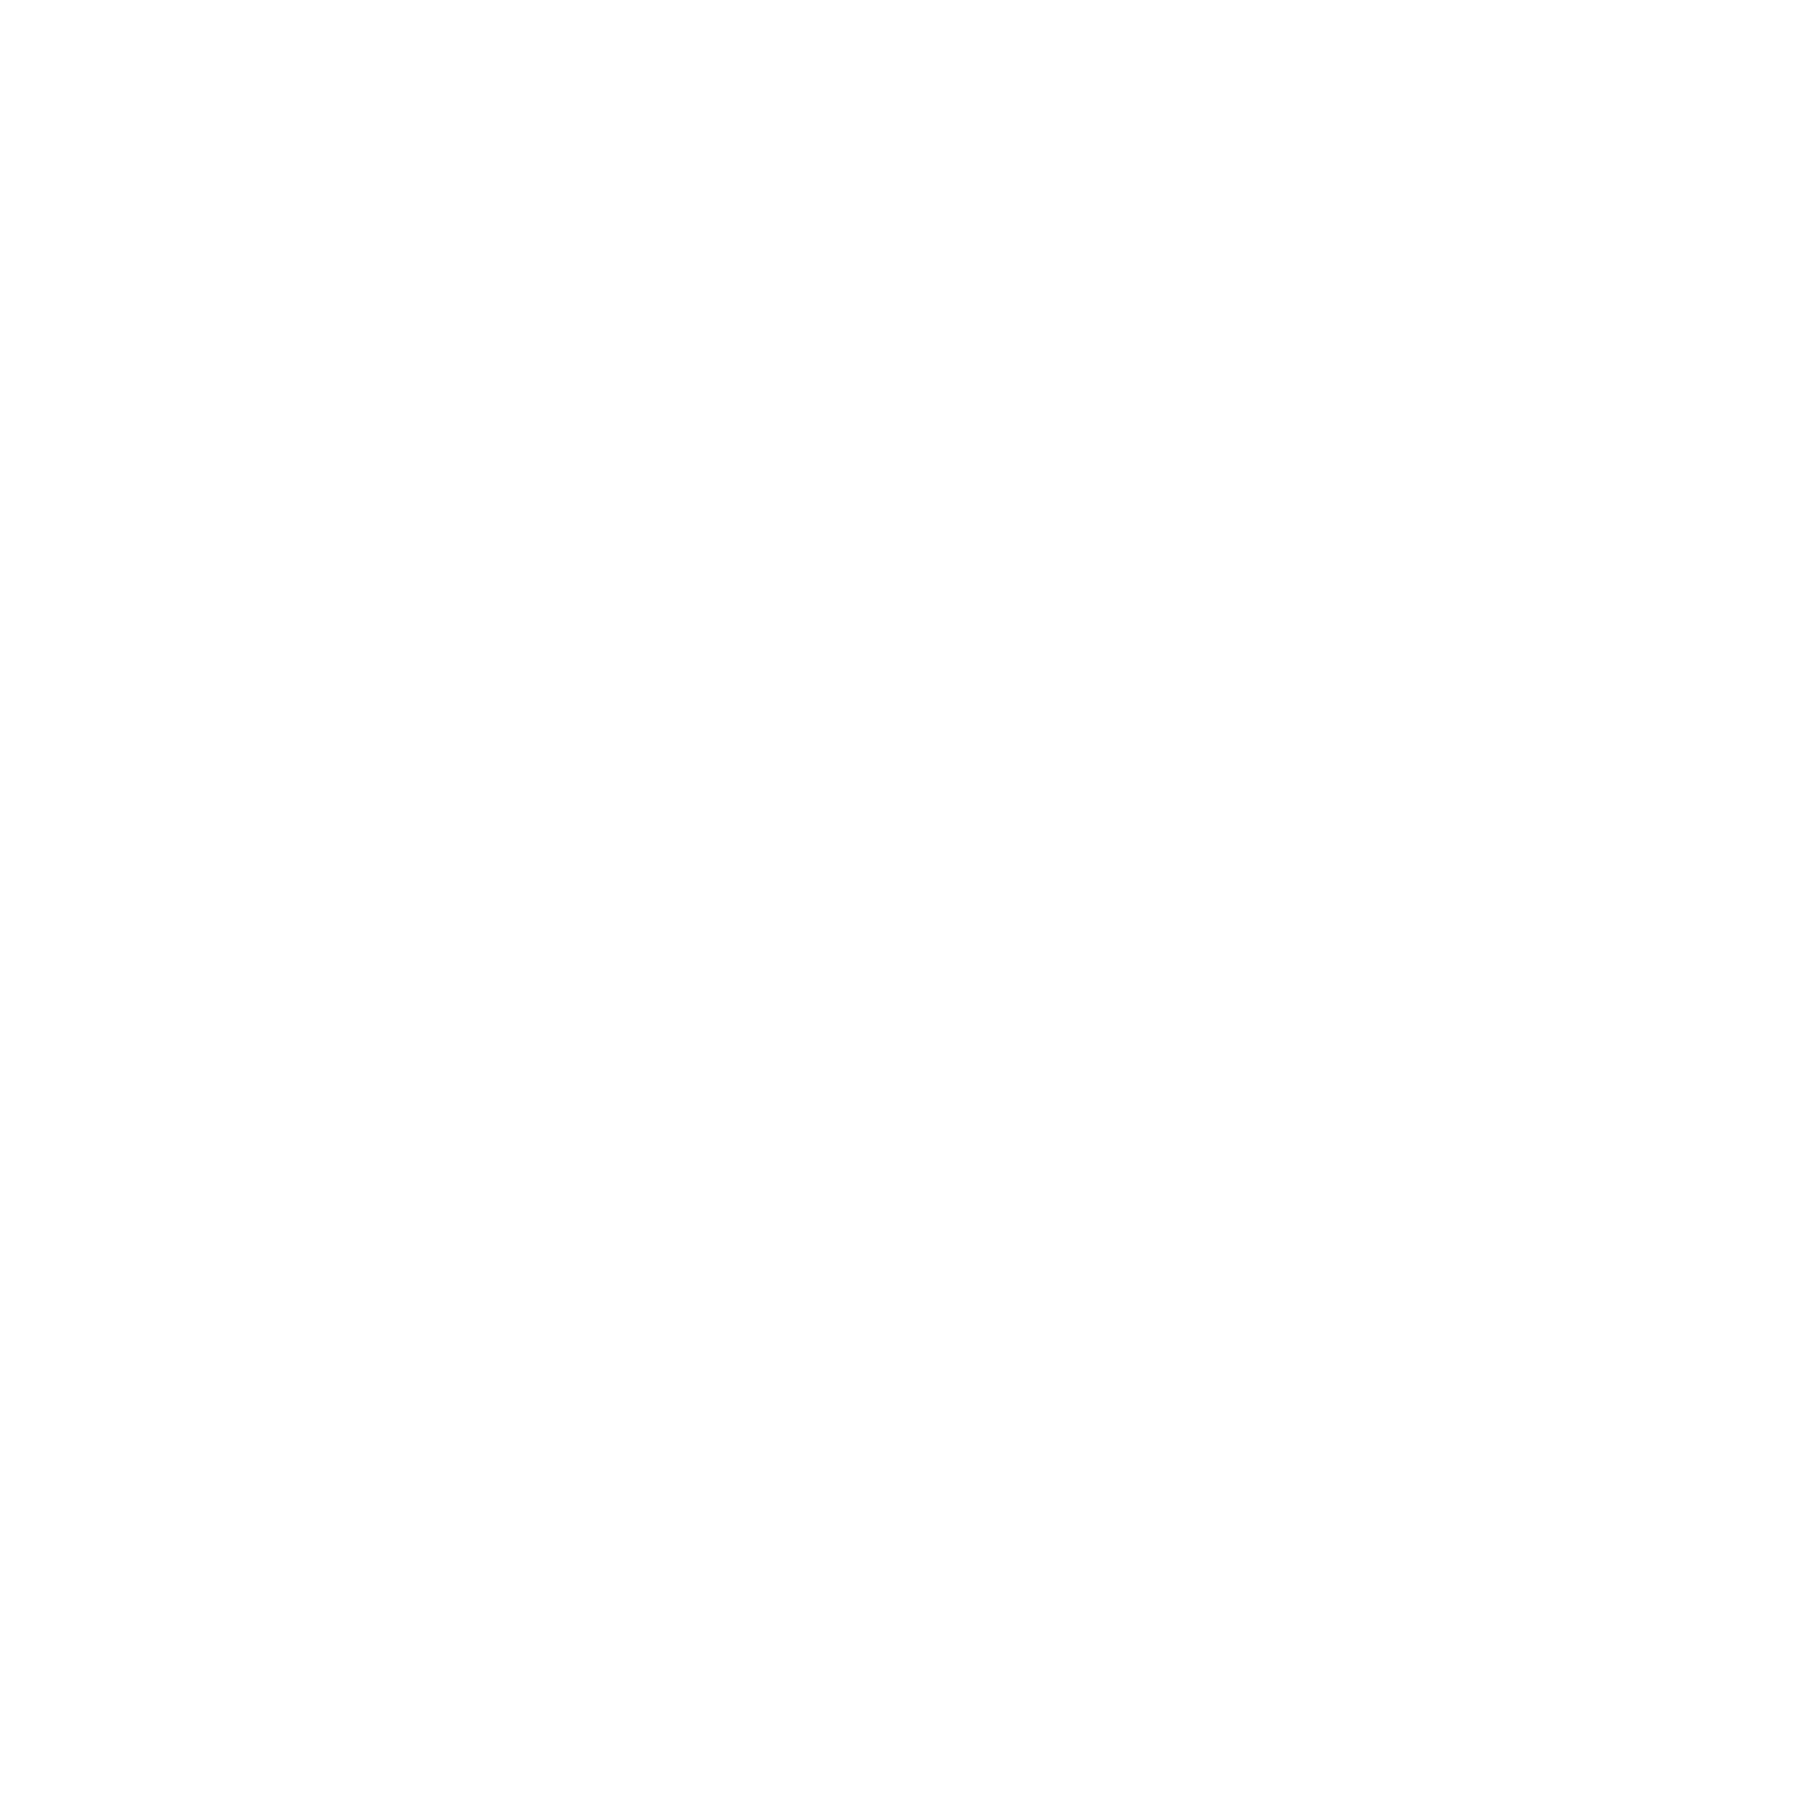

In [26]:
X = df_checkauc.iloc[:, 7:].values
y = df_checkauc.ID.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=77)
print('train set ratio : P {:,}, N {:,}'.format(len(np.where(y_train==1)[0]), len(np.where(y_train==0)[0])))
print('test set ratio : P {:,}, N {:,}'.format(len(np.where(y_test==1)[0]), len(np.where(y_test==0)[0])))
X_train.shape, y_train.shape, X_test.shape, y_test.shape

clf_multi_detect = RandomForestClassifier(n_estimators=200)
clf_multi_detect.fit(X_train, y_train)

# prediction
y_pred = clf_multi_detect.predict(X_test)
print(classification_report(y_test, y_pred))
# AUC
probs = clf_multi_detect.predict_proba(X_test)[:, 1]
rf_auc = roc_auc_score(y_test, probs)
print('rf auc : {}'.format(rf_auc))
# plot the roc curve for the model
rf_fpr, rf_tpr, _ = roc_curve(y_test, probs)
plt.figure(figsize=(4, 4))
plt.plot(rf_fpr, rf_tpr, marker='.', label='RF AUC = {:.4f}'.format(rf_auc), color='orange')
plt.title('ROC curve')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

In [27]:
clf_multi_detect_whole = RandomForestClassifier(n_estimators=200)
clf_multi_detect_whole.fit(X, y)

RandomForestClassifier(n_estimators=200)